![Logo](assets/logo.png)

Made by **Domonkos Nagy**

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/Fortuz/rl_education/blob/main/4.%20Monte%20Carlo/blackjack.ipynb)

# Blackjack

Blackjack is a card game where the goal is to beat the dealer by obtaining cards that sum to closer to 21 (without going over 21) than the dealers cards.
The game starts with the dealer having one face up and one face down card, while the player has two face up cards. All cards are drawn from an infinite deck (i.e. with replacement).

![Image of a blackjack game](assets/blackjack.png)

The card values are:

- Face cards (Jack, Queen, King) have a point value of 10.
- Aces can either count as 11 (called a ‘usable ace’) or 1.
- Numerical cards (2-9) have a value equal to their number.

The player has the sum of cards held. The player can request additional cards (*hit*) until they decide to stop (*stick*) or exceed 21 (*bust*, immediate loss).
After the player sticks, the dealer reveals their facedown card, and draws cards until their sum is 17 or greater. If the dealer goes bust, the player wins.
If neither the player nor the dealer busts, the outcome (win, lose, draw) is decided by whose sum is closer to 21. If the player has 21 immediately (an ace and a 10-card),
it is called a *natural*. The player then wins unless the dealer also has a natural, in which case the game is a draw.

We are going to use the `Blackjack-v1` environment of the `Gymnasium` library. The states are 3-component tuples, where the components are:

1. The player's current sum (0 - 31)
2. The dealer's face up card (1 - 10, where 1 is Ace)
3. Whether the player has a usable ace (0 for no, 1 for yes)

An action is either 0 (stick) or 1 (hit). The reward is +1 for winning the game, -1 for losing, and 0 for a draw.

This example uses an *Off-policy Monte Carlo* algorithm to approximate the optimal policy.

In [1]:
import gymnasium as gym
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time
import pickle
from tqdm.notebook import trange
from matplotlib.patches import Patch
from IPython import display
%config InlineBackend.print_figure_kwargs = {'pad_inches': .3}

In [2]:
env = gym.make('Blackjack-v1', sab=True, render_mode='rgb_array')  # sab for Sutton & Barto's version

In [3]:
action_space_size = env.action_space.n
state_space_shape = tuple([dim.n for dim in env.observation_space])
q_table_shape = state_space_shape + (action_space_size, )

q_table = np.zeros(q_table_shape)
weights = np.zeros(q_table_shape)

In [4]:
# hyperparameters
N_EPISODES = 10_000_000
EPSILON = 1
EPSILON_DECAY = EPSILON / (N_EPISODES / 2)
EPSILON_MIN = 0.1
GAMMA = 1
LOG_RATE = N_EPISODES / 10

## Off-policy Monte Carlo Control

Monte Carlo (MC) methods are iterative processes for finding the optimal policy and state-value function, similarly to Policy Iteration. However, instead
of doing sweeps of the complete state set, MC algorithms only simulate episodes. *Off-policy* means that the policy used to simulate episodes (*behaviour policy*) is different
from the policy learned (*target policy*): in this case, the target policy is a deterministic policy $\pi$, while the behaviour policy $b$ is an $\varepsilon$-greedy policy, that
uses $\pi$'s state-value function to determine the best action for each state.

Let's consider the *On-policy* version of this method first, that is, where the policy used to generate the episodes, $b$ is identical to the policy being evaulated, $\pi$. We simulate an episode using the policy, and save the resulting trajectory: $S_0, A_0, R_1, S_1, A_1, ..., S_{T-1}, A_{T-1}, R_T$ ($T$ is the terminal time step).
Looping backwards through the trajectory, we calculate the returns for each step, and update our value function so that the value of each state-action pair will be the
average of the returns observed after visiting that state and taking that action. After that, we update the policy according to the new action-value function. As long as the policy is $\varepsilon$-greedy, this method will converge to the best $\varepsilon$-soft policy (a policy is $\varepsilon$-soft if $\pi(a|s) > \frac{\varepsilon}{|\mathcal{A}(S_t)|}$ for all $a, s$).

In contrast, the Off-policy method uses different behaviour and target policies. In this case, when updating the action-value function, we have to take into account
the difference between $\pi(a|s)$ and $b(a|s)$, since we use data generated by using $b$ to better estimate the action-value function of $\pi$. We can account for this difference
by calculating the *importance-sampling ratio*:

$$ \rho_{t:T-1} := \prod_{k=t}^{T-1} \frac{\pi(A_k|S_k)}{b(A_k|S_k)} $$

Weighing the returns with the importance-sampling ratio lets us update the action-value function of $\pi$ using only data generated with $b$. Using this method we are not limited
to just $\varepsilon$-soft methods: while the behaviour policy is more exploratory, the target policy can be deterministic.

In [5]:
sum_rewards = 0

for episode in trange(N_EPISODES):
    state = env.reset()[0]

    done = False
    trajectory = []
    returns = 0
    weight = 1

    while not done:
        best_action = np.argmax(q_table[state])
        prob_choice = 1 - (EPSILON / 2)

        if np.random.rand() > EPSILON:
            action = best_action
        else:
            action = env.action_space.sample()
            if action != best_action:
                prob_choice = EPSILON / 2

        new_state, reward, done, truncated, info = env.step(action)
        trajectory.insert(0, (state, action, reward, prob_choice))

        sum_rewards += reward
        state = new_state

    for step in trajectory:
        state, action, reward, prob_choice = step

        # updating the returns
        returns = reward + GAMMA * returns
        ind = state + (action, )

        # updating the q-table
        weights[ind] += weight
        q_table[ind] += (weight / weights[ind]) * (returns - q_table[ind])

        # since the target policy is deterministic,
        # this means that the importance-sampling ratio 0
        if action != np.argmax(q_table[state]):
            break

        weight /= prob_choice

    EPSILON = max(EPSILON - EPSILON_DECAY, EPSILON_MIN)

    # logging the results
    if (episode + 1) % LOG_RATE == 0:
        print(f'Episode {episode + 1} : avg={sum_rewards / LOG_RATE}')
        sum_rewards = 0

# saving the q-table
with open('q_table.bin', 'wb') as f:
    pickle.dump(q_table, f)

  0%|          | 0/10000000 [00:00<?, ?it/s]

Episode 1000000 : avg=-0.361018
Episode 2000000 : avg=-0.292967
Episode 3000000 : avg=-0.224187
Episode 4000000 : avg=-0.152485
Episode 5000000 : avg=-0.088927
Episode 6000000 : avg=-0.081531
Episode 7000000 : avg=-0.0827
Episode 8000000 : avg=-0.078769
Episode 9000000 : avg=-0.079947
Episode 10000000 : avg=-0.081354


**Plotting the results**: The plots for the final state-value function and policy are shown below. The player sum below 12 (or above 21) is irrelevant, so it is not shown here:
in the with-usable-ace case, a sum less than 12 is not even possible, and in the no-usable-ace case, hitting is trivially better than sticking.

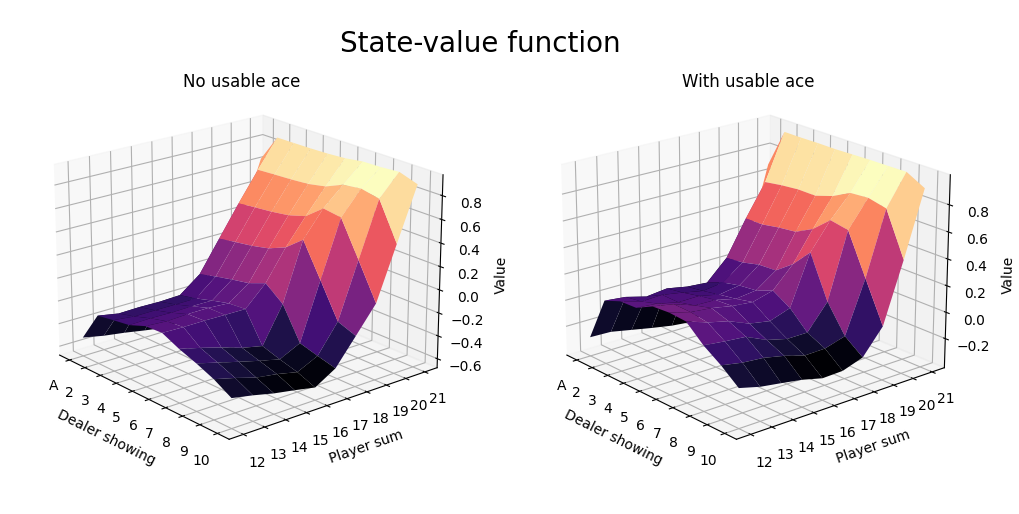

In [6]:
# getting the value functions
state_value_no_usable_ace = np.max(q_table[12:22, 1:, 0, :], axis=-1)
state_value_with_usable_ace = np.max(q_table[12:22, 1:, 1, :], axis=-1)

x_tick_labels = ['A'] + list(range(2, 11))  # 'Ace' instead of 1

x, y = np.meshgrid(np.arange(state_value_no_usable_ace.shape[0]),
                   np.arange(state_value_no_usable_ace.shape[1]))

fig, axs = plt.subplots(1, 2, figsize=(12, 6), subplot_kw={'projection': '3d'})
ax1, ax2 = axs

# options for both plots
plt.setp(axs, xticks=np.arange(10),
         xticklabels=x_tick_labels,
         yticks=np.arange(10), yticklabels=np.arange(12, 22),
         xlabel='Dealer showing', ylabel='Player sum', zlabel='Value')

# 'no usable ace' plot
ax1.plot_surface(x, y, state_value_no_usable_ace, cmap='magma')
ax1.view_init(20, -40)
ax1.set_title('No usable ace', y=1)

# 'with usable ace' plot
ax2.plot_surface(x, y, state_value_with_usable_ace, cmap='magma')
ax2.view_init(20, -40)
ax2.set_title('With usable ace', y=1)

fig.suptitle('State-value function', fontsize=20, y=0.9)
plt.show()

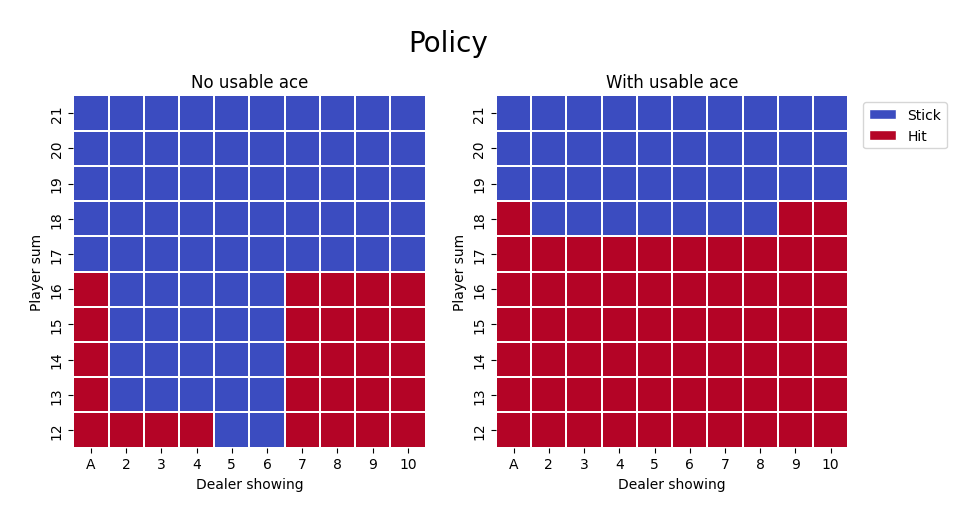

In [7]:
# getting the policies
policy_no_usable_aces = np.argmax(q_table[12:22, 1:, 0, :], axis=-1)
policy_with_usable_aces = np.argmax(q_table[12:22, 1:, 1, :], axis=-1)

fig, axs = plt.subplots(1, 2, figsize=(10, 5))
ax1, ax2 = axs

# 'no usable ace' plot
sns.heatmap(np.flip(policy_no_usable_aces, axis=0), cmap='coolwarm',
            linecolor='white', linewidths=0.05, square=True,
            yticklabels=np.arange(21, 11, -1),
            xticklabels=x_tick_labels,
            cbar=False, ax=ax1)
ax1.set_title('No usable ace')

# 'with usable ace' plot
sns.heatmap(np.flip(policy_with_usable_aces, axis=0), cmap='coolwarm',
            linecolor='white', linewidths=0.05, square=True,
            yticklabels=np.arange(21, 11, -1),
            xticklabels=x_tick_labels,
            cbar=False, ax=ax2)
ax2.set_title('With usable ace')

# options for both plots
plt.setp(axs, xlabel='Dealer showing', ylabel='Player sum')

legend_elements = [
        Patch(facecolor="#3b4cc0", edgecolor="white", label="Stick"),
        Patch(facecolor="#b50526", edgecolor="white", label="Hit"),
    ]

fig.suptitle('Policy', fontsize=20)
plt.legend(handles=legend_elements, bbox_to_anchor=(1.3, 1))
plt.show()

**Playing the game**: Here we simulate 3 episodes using the resulting policy:

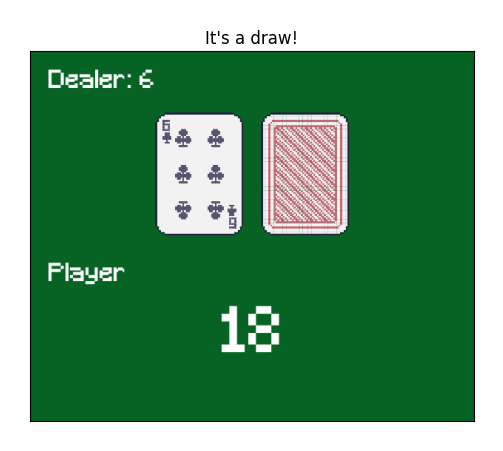

In [8]:
env = gym.make('Blackjack-v1', sab=True, render_mode='rgb_array')

# loading the q-table
with open('q_table.bin', 'rb') as f:
    q_table = pickle.load(f)

plt.tick_params(left=False, right=False, labelleft=False,
                labelbottom=False, bottom=False)

env.reset()
img = plt.imshow(env.render())
for episode in range(3):
    plt.title(f"Episode #{episode+1}")

    state = env.reset()[0]

    img.set_data(env.render())
    display.display(plt.gcf())
    display.clear_output(wait=True)
    time.sleep(1)

    done = False

    while not done:
        action = np.argmax(q_table[state])  # greedy policy
        new_state, reward, done, truncated, info = env.step(action)

        img.set_data(env.render())
        display.display(plt.gcf())
        display.clear_output(wait=True)

        if done:
            if reward == 1:
                plt.title("You win!")
            elif reward == -1:
                plt.title("You lose!")
            else:
                plt.title("It's a draw!")

            display.display(plt.gcf())
            display.clear_output(wait=True)

        time.sleep(1)

        state = new_state

env.close()